In [125]:
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
import time
import xarray
import glob
import json
import matplotlib.animation as animation
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12) # Large figures/
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/lcrc/soft/climate/e3sm-unified/base/envs/e3sm_unified_1.6.0rc7_anvil/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [137]:
#this allows for in movies in the notebook
%matplotlib notebook


In [ ]:
#point to mesh relevant for this run
me = xarray.open_dataset('/lcrc/group/e3sm/public_html/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc')
me = xarray.open_dataset('/lcrc/group/e3sm/public_html/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3_80Layer.restartFromAnvil.171031.nc')

In [ ]:
#Point to data to read, wildcards allow for movie
flist = sorted(glob.glob('/lcrc/group/e3sm/ac.cbegeman/scratch/anvil/20211020.GMPAS-JRA1p4.TL319_EC30to60E2r2.vlr.anvil/run/*mpaso.hist.am.timeSeriesStatsMonthly.*'))
flist = sorted(glob.glob('/lcrc/group/e3sm/ac.fspereira/scratch/chrys/20210421_sim7_CORE_18to6v3/run/*mpaso.hist.am.timeSeriesStatsMonthly.*'))


In [ ]:
#input path to geojson file of transect
path_json = '/home/ac.vanroekel/transect.json'

In [ ]:
#input number of points for inverse distance weighted average to transect
npts = 3
#input slice # of start and end in the flist array (above)
nt1 = 20
nt2 = 80

#field for transect -- can change and just rerun where it occurs below
fldName = 'timeMonthly_avg_BruntVaisalaFreqTop' 

In [21]:
def lon_lat_to_cartesian(lon, lat, R = 6370000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)
    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x,y,z

In [22]:
with open(path_json) as f:
    data = json.load(f)

In [23]:
ns = len(feature['geometry']['coordinates'])
latT = np.zeros(ns)
lonT = np.zeros(ns)
for i in range(ns):
    latT[i] = feature['geometry']['coordinates'][i][1]
    lonT[i] = feature['geometry']['coordinates'][i][0]

In [151]:
nz = me.dims['nVertLevels']
bd = -me.refBottomDepth.values

In [152]:
lonS = me.lonCell.values*180./np.pi
latS = me.latCell.values*180./np.pi
inds = np.where(lonS > 180)[0]
lonS[inds] -= 360

In [153]:
xs, ys, zs = lon_lat_to_cartesian(lonS, latS)
xt, yt, zt = lon_lat_to_cartesian(lonT, latT)

In [154]:
tree = cKDTree(list(zip(xs, ys, zs)))
#find indices of the nearest neighbors in the flattened array
d, inds = tree.query(list(zip(xt, yt, zt)), k = npts)
#get interpolated 2d field
w = 1.0 / d**2
#air_idw = np.sum(w * air.flatten()[inds], axis=1) / np.sum(w, axis=1)

In [155]:
uInds = np.unique(inds)

In [156]:
#create a mask
temp = me.temperature[0,uInds,:].values
inds1 = np.where(temp < -10)[0]
inds2 = np.where(temp < -10)[1]
mask = np.ones_like(temp)
mask[inds1,inds2] = np.nan

In [157]:
maskT = np.zeros((ns,nz))

ivals = np.ones_like(inds)
for i in range(ns):
    for k in range(npts):
        ivals[i,k] = (abs(uInds-inds[i,k]).argmin())
    maskT[i,:] = mask[ivals[i,0],:]

In [158]:
#need distance across transect
latLR = latT*np.pi/180.
lonLR = lonT*np.pi/180.
lrdist = np.zeros(ns)
for i in range(1,ns):
    a = np.sin((latLR[i]-latLR[i-1])/2)**2 + \
                                  np.cos(latLR[i])*np.cos(latLR[i-1])*np.sin((lonLR[i]-lonLR[i-1])/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    lrdist[i] = lrdist[i-1] + 6371229*c

In [164]:
nt = nt2 - nt1 + 1
transect2 = np.zeros((nt, ns,nz))

t=0
for j in range(nt1,nt2+1):
    ds = xarray.open_dataset(flist[j])
    fld = ds[fldName][0,uInds,:].values

    for i in range(ns):
        transect2[t,i,:] = np.nansum(fld[ivals[i,:],:]*mask[ivals[i,:],:]*w[i,:,np.newaxis],axis=0) / np.sum(w[i,:])
    ds.close()
    t+=1

In [165]:
def animate(i):
    ax.cla()
    pcm=ax.contourf(lrdist/1000,bd,(maskT*transect2[i,:,:]).T,np.linspace(minv,maxv),extend='both',cmap='viridis')
  #  fig.colorbar(pcm, ax=ax)
#    ax.contour(lats[sp]*180./np.pi,-me.refBottomDepth.values,anom[i,:,:].T,np.linspace(minv,maxv,11),colors='black',cmap=None,extend='both')
    ax.set_title('File Index {}'.format(i),fontsize=32)
    ax.set_ylim(-1000,0)

In [166]:
minv = 0
maxv = 5e-4

<IPython.core.display.Javascript object>


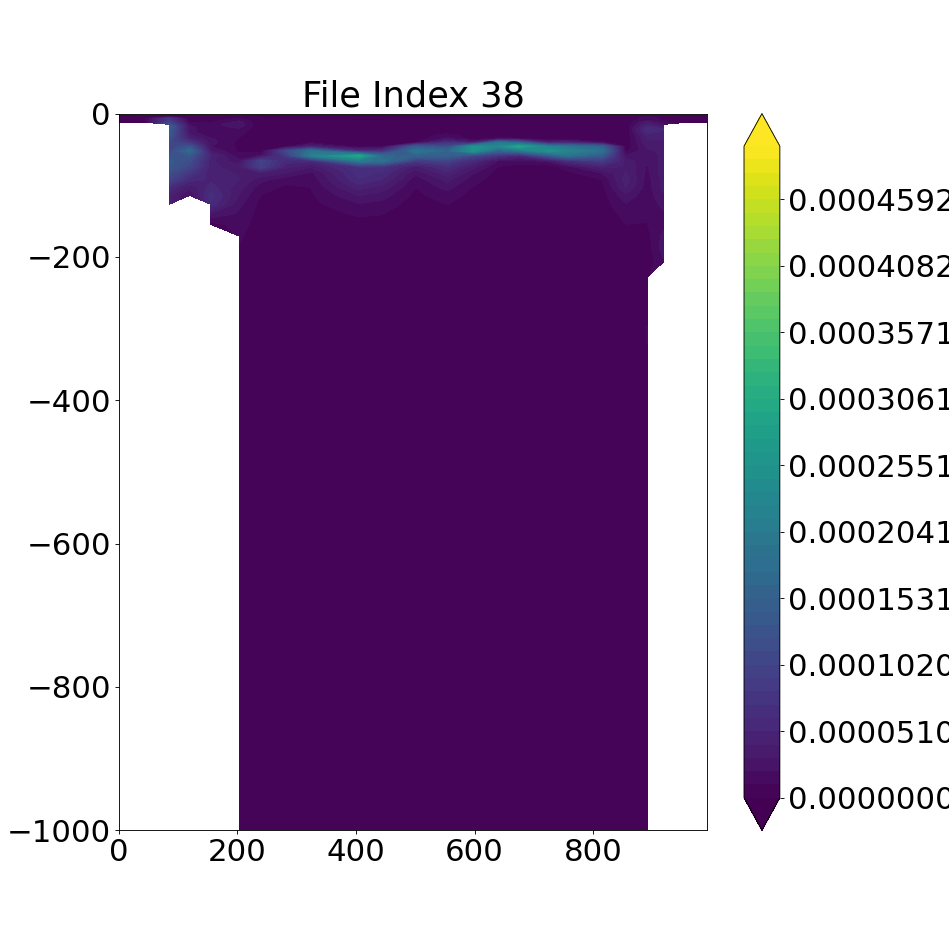

In [167]:
fig,ax = plt.subplots()
ax.cla()

i=1
pcm=ax.contourf(lrdist/1000,bd,(maskT*transect2[i,:,:]).T,np.linspace(minv,maxv),extend='both',cmap='viridis')
#  fig.colorbar(pcm, ax=ax)
#    ax.contour(lats[sp]*180./np.pi,-me.refBottomDepth.values,anom[i,:,:].T,np.linspace(minv,maxv,11),colors='black',cmap=None,extend='both')
ax.set_title('File Index {}'.format(i),fontsize=32)
ax.set_ylim(-1000,0)
    
ani = animation.FuncAnimation(fig,animate,frames=range(1,nt),interval=100)
fig.colorbar(pcm,ax=ax)
plt.show()
